In [1]:
import commonsetting
from models import perceptual_network, Encoder, Class_out, Conf_out
from dataloader import CustomImageDataset, concatenate_transform_steps
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch import nn
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd


if __name__ == "__main__":
    pretrained_model_name   = commonsetting.pretrained_model_name
    hidden_layer_size       = commonsetting.hidden_layer_size
    hidden_activation_name  = commonsetting.hidden_activation_name
    hidden_activation       = commonsetting.hidden_activation
    hidden_dropout          = commonsetting.hidden_dropout
    resize                  = commonsetting.image_resize
    in_shape                = (1,3,resize,resize)

    SimpleCNN_args = dict(
        pretrained_model_name   = pretrained_model_name,
        hidden_layer_size       = hidden_layer_size,
        hidden_activation       = hidden_activation,
        hidden_dropout          = hidden_dropout,
        hidden_layer_type       = commonsetting.hidden_layer_type,
        output_layer_size       = commonsetting.output_layer_size,
        in_shape                = (1,3,resize,resize),
        retrain_encoder         = commonsetting.retrain_encoder,
        device                  = commonsetting.device,
        )
        

    tranformer_steps = concatenate_transform_steps(image_resize=commonsetting.image_resize, rotate=0)

    dataset_test = CustomImageDataset(commonsetting.test_dir,label_map=commonsetting.label_map , transform=tranformer_steps)
    dataloader_test = DataLoader(dataset_test, batch_size=commonsetting.batch_size, shuffle=True, num_workers=commonsetting.num_workers)
    SimpleCNN = perceptual_network(**SimpleCNN_args)
    SimpleCNN.load_state_dict(torch.load("../models/train_mixed_weight/simplecnn_b32e4i224h300w2601.h5"))
    for p in SimpleCNN.parameters(): p.requires_grad = False
    # define loss function
    classification_loss = nn.BCELoss()
    # when there is no noise
    SimpleCNN.eval()
    SimpleCNN.to(commonsetting.device)
    with torch.no_grad():
        # extract features of each image
        y_true = []
        y_pred = []
        y_correct_pred = []
        confidence_out = []
        for idx_batch, (batch_image, batch_label) in tqdm(enumerate(dataloader_test)):
            batch_label = torch.vstack(batch_label).T.float()
            #记得每一次处理数据之前要做这一步
            batch_image = batch_image.to(commonsetting.device)
            batch_label = batch_label.to(commonsetting.device)
            
            features,hidden_representation,prediction, confidence =  SimpleCNN(batch_image.to(commonsetting.device))
            correct_preds = batch_label.clone().detach().argmax(1)==prediction.clone().detach().argmax(1)
            correct_preds = correct_preds.float()

            correct_preds = torch.vstack([1-correct_preds, correct_preds]).T.float()
            
            
            y_correct_pred.append(correct_preds.detach().cpu().numpy())
            y_true.append(batch_label.detach().cpu().numpy())
            y_pred.append(prediction.detach().cpu().numpy())
            confidence_out.append(confidence.detach().cpu().numpy())
    
    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    y_correct_pred = np.concatenate(y_correct_pred, axis=0)
    confidence_out = np.concatenate(confidence_out, axis=0)


12it [00:03,  3.25it/s]


In [2]:
from sklearn.metrics import roc_auc_score, accuracy_score

In [3]:
roc_auc_score(y_true, y_pred)

0.7867939814814816

In [4]:
roc_auc_score(y_correct_pred, confidence_out)

0.6496077935222673

In [5]:
y_pred.shape

(360, 3)

In [6]:
from collections import Counter
Counter(y_pred.argmax(1))

Counter({2: 104, 0: 170, 1: 86})

In [7]:
from matplotlib import pyplot as plt

(array([ 4.,  3., 11., 12., 28., 66., 90., 77., 53., 16.]),
 array([0.16525538, 0.20818025, 0.25110513, 0.29402998, 0.33695486,
        0.37987971, 0.42280459, 0.46572945, 0.5086543 , 0.55157918,
        0.59450406]),
 <BarContainer object of 10 artists>)

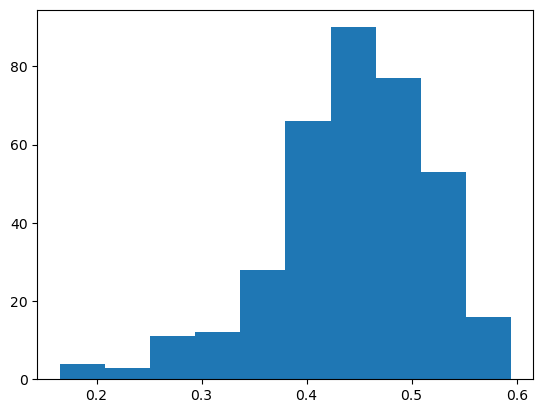

In [8]:
plt.hist(confidence_out[:,0])

In [9]:
confidence_onehot = np.vstack([1-confidence_out.argmax(1), confidence_out.argmax(1)]).T

In [10]:
response = y_pred.argmax(1) == 1

In [11]:
rating = confidence_out.argmax(1) == 1

In [12]:
from collections import Counter
Counter(y_correct_pred[:,1])

Counter({1.0: 208, 0.0: 152})

In [13]:
df_cnn = pd.DataFrame({"response":response.astype(int).tolist(), 
              "stim":y_true[:, 1].astype(int).tolist(), 
             "acc":y_correct_pred[:, 1].astype(int).tolist(), 
             "confidence":rating.astype(int).tolist()})

In [14]:
def type2_proba(data):
    data_result = {'proba_low_correct':[], 
                   'proba_high_correct':[], 
                  'proba_low_incorrect':[],
                  'proba_high_incorrect':[], 
                  'proba_correct':[]}
    
    confidence_onehot = np.vstack([1-data["confidence"], data["confidence"]]).T
    
    idx_correct_trial = data["acc"] == 1#正确的trial
    idx_incorrect_trial = data["acc"] == 0#错误的trial
    
    total_correct = sum(idx_correct_trial.astype(int))
    total_incorrect = sum(idx_incorrect_trial.astype(int))
    prob_correct = total_correct/len(data["acc"])
    correct_confidence =confidence_onehot[:, 1][idx_correct_trial]
    
    low_confidence = confidence_onehot[:, 0]
    high_confidence = confidence_onehot[:, 1]
    
    low_correct =  sum(low_confidence[idx_correct_trial])/ total_correct
    low_incorrect = sum(low_confidence[idx_incorrect_trial])/ total_incorrect
    
    high_correct = sum(high_confidence[idx_correct_trial])/ total_correct
    high_incorrect = sum(high_confidence[idx_incorrect_trial])/ total_incorrect
    
    data_result['proba_low_correct'].append(low_correct)
    data_result['proba_high_correct'].append(high_correct)
    data_result['proba_low_incorrect'].append(low_incorrect)
    data_result['proba_high_incorrect'].append(high_incorrect)
    data_result['proba_correct'].append(prob_correct)
    return  pd.DataFrame(data_result)

In [15]:
type2_proba(df_cnn)

,proba_low_correct,proba_high_correct,proba_low_incorrect,proba_high_incorrect,proba_correct
0,0.153846,0.846154,0.342105,0.657895,0.577778


In [16]:
df_sub3 = pd.read_csv("../data/sub/sub3_metad.csv")

In [17]:
df_sub3 = df_sub3.rename(columns = {"rating":"confidence"})

In [18]:
def confidence_value(x):
    if x["confidence"] == 2:
        return 1
    else:
        return 0

In [19]:
df_sub3["confidence"] = df_sub3.apply(lambda x: confidence_value(x), axis=1)

In [20]:
type2_proba(df_sub3)

,proba_low_correct,proba_high_correct,proba_low_incorrect,proba_high_incorrect,proba_correct
0,0.122881,0.877119,0.619048,0.380952,0.789298


In [21]:
#df_cnn.to_csv("../data/sub/cnn.csv")

In [22]:
df_cnn["count"] = 1
df_cnn.groupby(["stim", "response", "confidence"])["count"].count()

stim  response  confidence
0     0         0              43
                1             167
      1         0              14
                1              16
1     0         0              17
                1              47
      1         0              10
                1              46
Name: count, dtype: int64

In [23]:
df_sub3["count"] = 1
df_sub3.groupby(["stim", "response", "confidence"])["count"].count()

stim  response  confidence
0     0         0              29
                1             135
      1         0              15
                1              12
1     0         0              12
                1               4
      1         0              12
                1              80
Name: count, dtype: int64

In [24]:
from fit_meta_d_MLE import fit_meta_d_MLE

In [25]:
CNN_nR_S1 = [167,43, 14, 16]
CNN_nR_S2 = [47, 17, 10, 46]

fit_cnn = fit_meta_d_MLE(CNN_nR_S1,CNN_nR_S2)


/root/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/root/autodl-tmp/CNN_Moral-MetaCog/script/fit_meta_d_MLE.py:198: RuntimeWarning: divide by zero encountered in log
  + nI_rS2[i]*np.log(prI_rS2[i]) for i in range(nRatings)])


`xtol` termination condition is satisfied.
Number of iterations: 111, function evaluations: 556, CG iterations: 185, optimality: 3.74e-06, constraint violation: 0.00e+00, execution time:  1.1 s.


In [26]:
sub2_nR_S1 = [135, 29, 15, 12]
sub2_nR_S2 = [4, 12, 12, 80]

fit_sub2 = fit_meta_d_MLE(sub2_nR_S1,sub2_nR_S2)

/root/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 102, function evaluations: 492, CG iterations: 175, optimality: 8.04e-07, constraint violation: 0.00e+00, execution time: 0.94 s.


In [27]:
print("The drpime of CNN is ", fit_cnn['da'])
print("The meta drpime of CNN is ", fit_cnn['meta_da'])
print("-----------------------------------------------")
print("The drpime of real subject 2 is ", fit_sub2['da'])
print("The meta drpime of real subject 2 is ", fit_sub2['meta_da'])

The drpime of CNN is  1.0666976464688789
The meta drpime of CNN is  0.5950653394482528
-----------------------------------------------
The drpime of real subject 2 is  2.1186323152920803
The meta drpime of real subject 2 is  2.481763276567043
